# Liquidity_Trap by GPT - Strategy - Backtesting 

### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [6]:
def prepare_data(df):
    df['New_High'] = df['High'] > df['High'].rolling(10).max().shift(1)
    df['Rejection_Candle'] = (df['Close'] < (df['High'] - (df['High'] - df['Low']) * 0.25))
    df['Volume_Spike'] = df['Volume'] > df['Volume'].rolling(10).mean() * 1.3
    
    df['Liquidity_Trap'] = df['New_High'] & df['Rejection_Candle'] & df['Volume_Spike']
    return df

In [7]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [8]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.Liquidity_Trap[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if signal == True:
            sell_price = close_price
            sl = sell_price + 3
            tp = sell_price - self.reward_on_risk * 3
            self.sell(size=1, sl=sl, tp=tp)

In [9]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [10]:
stats

Start                     2020-11-02 09:00:00
End                       2025-02-25 14:45:00
Duration                   1576 days 05:45:00
Exposure Time [%]                   19.101369
Equity Final [$]                    1264.1436
Equity Peak [$]                    1510.46213
Return [%]                          -15.72376
Buy & Hold Return [%]               51.072103
Return (Ann.) [%]                   -3.927279
Volatility (Ann.) [%]                 5.52821
Sharpe Ratio                        -0.710407
Sortino Ratio                       -0.943683
Calmar Ratio                        -0.240827
Max. Drawdown [%]                  -16.307495
Avg. Drawdown [%]                   -1.389852
Max. Drawdown Duration     1561 days 01:35:00
Avg. Drawdown Duration      120 days 22:58:00
# Trades                                 1059
Win Rate [%]                        31.350331
Best Trade [%]                       0.935325
Worst Trade [%]                     -0.573881
Avg. Trade [%]                    

In [11]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,70,100,908.72730,909.0,-0.27270,-0.000300,2020-11-03 10:35:00,2020-11-03 14:30:00,None,0 days 03:55:00
1,-1,117,122,909.92694,913.0,-3.07306,-0.003377,2020-11-04 10:15:00,2020-11-04 10:40:00,None,0 days 00:25:00
2,-1,124,144,913.52586,916.8,-3.27414,-0.003584,2020-11-04 10:50:00,2020-11-04 13:55:00,None,0 days 03:05:00
3,-1,146,151,916.52496,913.5,3.02496,0.003300,2020-11-04 14:05:00,2020-11-04 14:30:00,None,0 days 00:25:00
4,-1,167,179,915.82517,919.0,-3.17483,-0.003467,2020-11-05 10:10:00,2020-11-05 11:10:00,None,0 days 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...
1054,-1,47938,47960,1248.22542,1239.5,8.72542,0.006990,2024-08-08 11:00:00,2024-08-08 14:15:00,None,0 days 03:15:00
1055,-1,47977,48000,1252.12425,1255.5,-3.37575,-0.002696,2024-08-09 10:00:00,2024-08-09 13:20:00,None,0 days 03:20:00
1056,-1,48001,48002,1254.12365,1257.8,-3.67635,-0.002931,2024-08-09 13:25:00,2024-08-09 13:30:00,None,0 days 00:05:00
1057,-1,48003,48006,1256.52293,1259.9,-3.37707,-0.002688,2024-08-09 13:35:00,2024-08-09 13:50:00,None,0 days 00:15:00


In [12]:
# bt.plot()

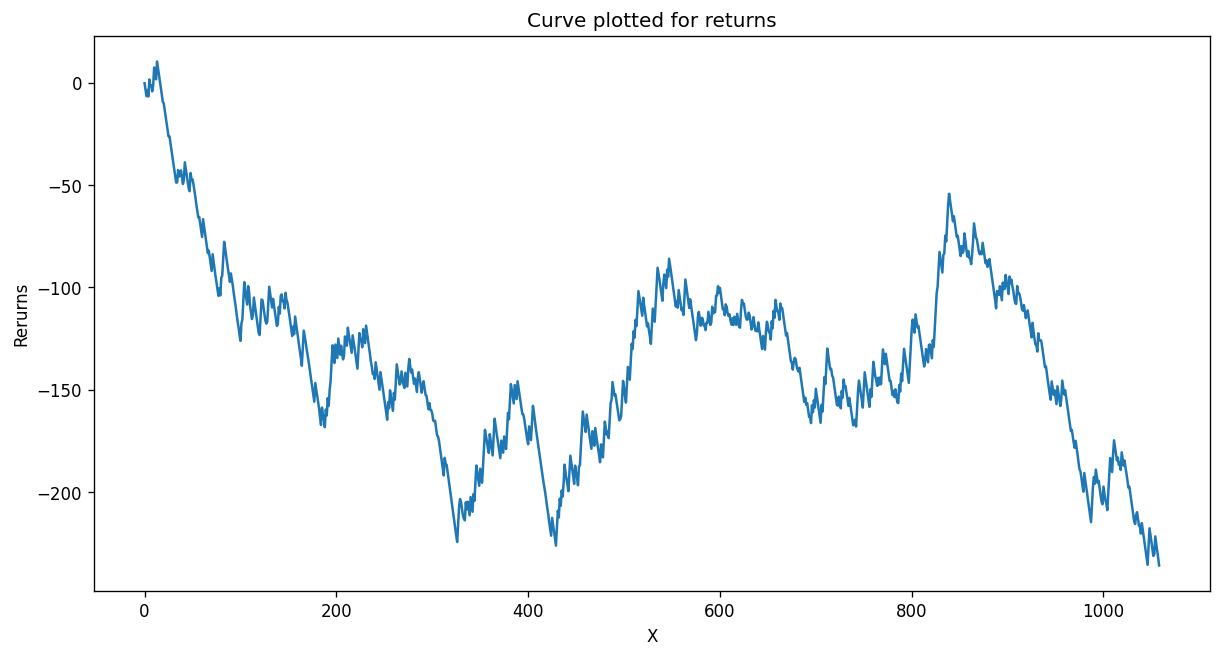

In [13]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()